In [3]:
%cd src

/content/src


### Reading data

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

This link will download the data: source text in English, target text in Russian

We will train the model on the task of translating from English to Russian.

In [ ]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

--2023-05-19 16:59:53--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15460248 (15M) [application/zip]
Saving to: ‘rus-eng.zip.2’

rus-eng.zip.2       100%[===================>]  14.74M  43.0MB/s    in 0.3s    

2023-05-19 16:59:54 (43.0 MB/s) - ‘rus-eng.zip.2’ saved [15460248/15460248]

Archive:  rus-eng.zip
replace rus.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: rus.txt                 
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: _about.txt              


### Import libraries

In [3]:
import torch
import yaml
import numpy as np
from models import trainer
from data.datamodule_t5 import DataManager
from txt_logger import TXTLogger
from data.tokenizer_t5 import T5Tokenizer
from models.seq2seq_t5 import Seq2SeqT5

### Data preparation

In [4]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
    
data_config = yaml.load(open("../configs/data_config.yaml", 'r'), Loader=yaml.Loader)
model_config = yaml.load(open("../configs/model_config.yaml", 'r'), Loader=yaml.Loader)
dm = DataManager(data_config, model_config)
train_dataloader, val_dataloader = dm.prepare_data()

Reading from file: 100%|██████████| 467119/467119 [00:06<00:00, 76307.90it/s]


### Initializing the model and training

In [5]:
model = Seq2SeqT5(model_config, 
                  device=DEVICE, 
                  target_tokenizer=dm.target_tokenizer, 
                  source_tokenizer=dm.source_tokenizer)

logger = TXTLogger('training_logs')
trainer_cls = trainer.Trainer(model=model, model_config=model_config, logger=logger)

trainer_cls.train(train_dataloader, val_dataloader)

100%|██████████| 100/100 [08:18<00:00,  4.99s/it]

Last 99 epoch train loss:  0.036508852848783135
Last 99 epoch val loss:  2.2318729162216187
Last 99 epoch val bleu:  0.23333869695206028


### Training parameters

In [32]:
import yaml

with open('../configs/model_config.yaml', 'r') as model_config:
    try:
        print(yaml.safe_load(model_config))
    except yaml.YAMLError as exc:
        print(exc)

{'model': 't5-small', 'token': 't5-small', 'embedding_size': 512, 'hidden_size': 512, 'learning_rate': 0.001, 'epoch_num': 100}


In [33]:
import yaml

with open('../configs/data_config.yaml', 'r') as data_config:
    try:
        print(yaml.safe_load(data_config))
    except yaml.YAMLError as exc:
        print(exc)

{'prefix_filter': ['he is', 'he s ', 'she is', 'she s '], 'max_length': 15, 'filename': 'rus.txt', 'train_size': 0.8, 'batch_size': 128}


### Translation examples

In [7]:
model.predict(['Hi, my name is Ignat', 
               'How are you?', 
               'He is artist', 
               'She likes tea', 
               'I love mother', 
               'Cat and dog', 
               'Moscow is a capital of Russia', 
               'The weather is good', 
               'What are you doing?', 
               'She is doing her homework'])

['то мо ависит',
 'то те а тее',
 'он удунк',
 'она лит еу',
 'он ли муа',
 'а кое и сука',
 'Mosа одес л',
 'он орои вес',
 'то тее а те',
 'она делает сво дома']

In [44]:
import random

source_text = []
true_target_text = []
predicted_target_text = []

with open('./rus.txt') as file:
    lines = [line.rstrip() for line in file]

n = 10
for i in range(n):
    seq = random.choice(lines)
    seq = seq.split('\t')
    source_text.append(seq[0])
    true_target_text.append(seq[1])

predicted_target_text = model.predict(source_text)

for i in range(n):
    print('source text: ', source_text[i])
    print('true target text: ', true_target_text[i])
    print('predicted target text: ', predicted_target_text[i])
    print('_________________________________________________')

source text:  Every morning she gets up early because she has to cook.
true target text:  Каждое утро она встаёт рано, потому что нужно стряпать.
predicted target text:  о весма она рано в
_________________________________________________
source text:  Don't tell anyone about this.
true target text:  Никому про это не говорите.
predicted target text:  то не луаетс
_________________________________________________
source text:  Even the dog ran away.
true target text:  Даже собака убежала.
predicted target text:  то не е ума
_________________________________________________
source text:  Do you go to school by train?
true target text:  Ты ездишь в школу на поезде?
predicted target text:  то ео колене
_________________________________________________
source text:  You can count on her.
true target text:  Вы можете на неё положиться.
predicted target text:  о моет е на 
_________________________________________________
source text:  I'm sorry I wasn't able to help you.
true target text:  

### Plots

In [15]:
import ast

path_to_logs = './training_logs/progress_log.txt'
train_loss = []
val_loss = []
bleu_score = []

with open(path_to_logs) as file:
    lines = [line.rstrip() for line in file]

for i in range(1,len(lines)):
    line_dict = ast.literal_eval(lines[i])
    train_loss.append(line_dict['train_loss'])
    val_loss.append(line_dict['val_loss'])
    bleu_score.append(line_dict['bleu_score'])

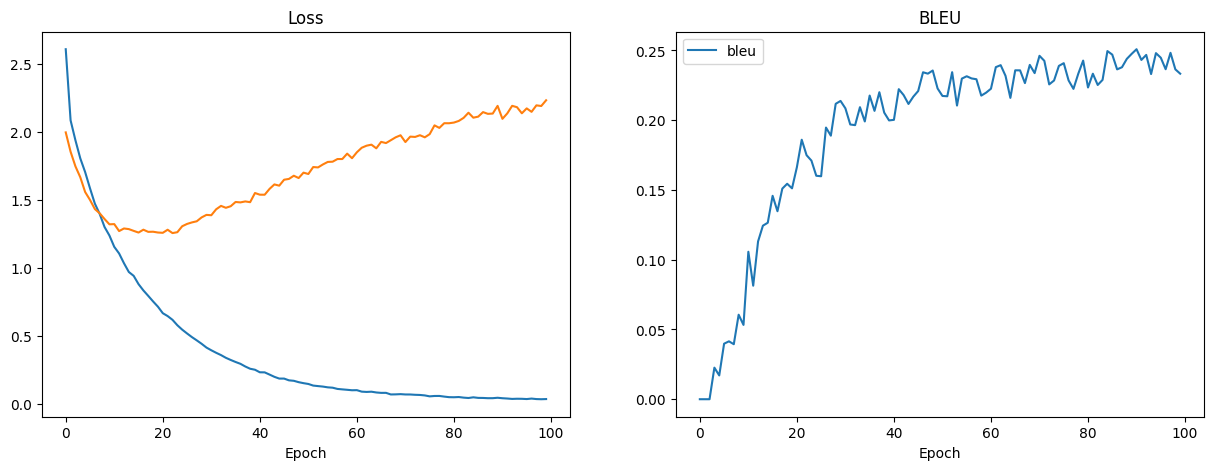

In [29]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax[0].plot(train_loss, label='train loss')
ax[0].plot(val_loss, label='val loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss')

ax[1].plot(bleu_score, label='bleu')
ax[1].set_xlabel('Epoch')
ax[1].set_title('BLEU')

plt.legend()
plt.show()